# 비대칭 데이터 문제
- https://imbalanced-learn.org/stable/over_sampling.html
-https://datascienceschool.net/03%20machine%20learning/14.02%20%EB%B9%84%EB%8C%80%EC%B9%AD%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%AC%B8%EC%A0%9C.html

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import numpy as np
import pandas as pd

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


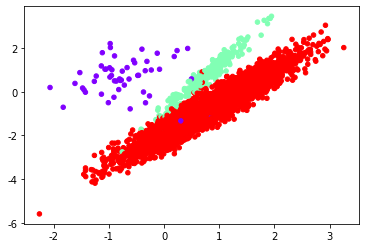

In [ ]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=5000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, 
                           n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.01, 0.05, 0.94],
                           class_sep=0.8, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='rainbow')

## SMOTE
- 가우시안 나이브 등과 같은 알고리즘은 Class weight 파라미터가 없음

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print(f'normal data distribution: {Counter(y)}')
X_smote, y_smote = SMOTE().fit_resample(X,y)
print(f'SMOTE data distribution: {Counter(y_smote)}')

normal data distribution: Counter({2: 4674, 1: 262, 0: 64})
SMOTE data distribution: Counter({2: 4674, 1: 4674, 0: 4674})


## 원래 데이터로 예측

In [ ]:
from sklearn import model_selection, metrics
from imblearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
clf = LinearSVC()
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=11)

model_selection.cross_validate(clf, X, y, scoring='recall_macro', cv=kf)
print('\n')
model_selection.cross_val_score(clf, X, y, scoring='recall_macro', cv=kf)

{'fit_time': array([0.04195499, 0.03774571, 0.03039002]),
 'score_time': array([0.00170231, 0.00151706, 0.00151277]),
 'test_score': array([0.69340238, 0.56378601, 0.59348149])}

array([0.69340238, 0.56378601, 0.59348149])

## Data over-under-combine

In [ ]:
from imblearn.over_sampling import *
oversamplers = [RandomOverSampler(random_state=0), ADASYN(random_state=0),
                SMOTE(random_state=42)]
                
for sampler in oversamplers :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)
    print('\n')

array([0.8378122 , 0.82726718, 0.82383264])

array([0.53418115, 0.5825033 , 0.71177491])

array([0.84221685, 0.83272696, 0.82319038])

In [ ]:
borderline_smote = [BorderlineSMOTE(random_state=13), SVMSMOTE(random_state=11)]
for sampler in borderline_smote :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)
    print('\n')

array([0.82447722, 0.86502517, 0.87378737])

array([0.8946434 , 0.91022688, 0.88909526])

In [ ]:
from imblearn.under_sampling import *
undersamplers = [RandomUnderSampler(), TomekLinks(), OneSidedSelection()]
for sampler in undersamplers :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)
    print('\n')

array([0.83115841, 0.83023519, 0.83068342])

array([0.71716125, 0.57201646, 0.61246442])

array([0.74836692, 0.79947624, 0.79414838])

In [ ]:
from imblearn.combine import *
combinesamplers = [SMOTEENN(random_state=0), SMOTETomek(random_state=4)]
for sampler in combinesamplers :
    imba_pipeline= make_pipeline(sampler, clf)
    model_selection.cross_val_score(imba_pipeline, X, y, scoring='recall_macro', cv=kf)
    print('\n')

array([0.86445475, 0.86012321, 0.83558527])

array([0.84414859, 0.83571076, 0.82468899])

# Ensemble of samplers
## Classifier including inner balancing samplers
https://imbalanced-learn.org/stable/ensemble.html
###  Bagging classifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier

bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=0) 
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0)

for classifier in [bag, brf, rusboost] :
    model_selection.cross_val_score(classifier, X, y, scoring='recall_macro', cv=kf)
    print('\n')

array([0.86744119, 0.88333391, 0.85821205])

array([0.88380873, 0.88856932, 0.85341355])

array([0.55950734, 0.51173524, 0.57998663])

# 데이터 제거

In [ ]:
from sklearn.datasets import fetch_openml
data = fetch_openml(name='CreditCardFraudDetection')
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df['log_Amount'] = np.log(1+df['Amount'])
data = df.sample(frac=0.1, random_state=135).copy()
data.head()
data.shape
print('\n')
data.target.value_counts(normalize=True)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,target,log_Amount
206709,136330.0,2.108286,-0.020359,-2.234273,-0.124080,0.559843,-1.315913,0.631887,-0.385490,0.150628,...,0.519705,-0.091751,-0.379542,0.418822,0.248646,-0.098857,-0.094773,7.70,0.0,2.163323
164567,116819.0,2.080143,-0.075408,-1.359381,0.261263,0.232201,-0.797886,0.233487,-0.330165,0.493154,...,-0.784150,0.233078,-0.636937,-0.191137,0.234986,-0.070648,-0.062794,17.99,0.0,2.943913
16546,27917.0,1.152650,0.204938,0.441832,1.211595,-0.254895,-0.383380,-0.004286,-0.019590,0.085094,...,0.209828,-0.054351,0.058103,0.515330,-0.299402,0.032551,0.022865,21.00,0.0,3.091042
152705,97443.0,-0.389692,0.410148,0.616187,-0.686644,1.040312,-0.322199,0.523625,-0.037453,1.319237,...,0.685267,-0.182303,0.767857,-0.242738,0.009678,0.115370,0.176041,6.60,0.0,2.028148
10646,17920.0,-1.306986,0.183306,3.164803,0.810135,1.529576,2.388322,0.551279,-0.054401,1.675481,...,0.556523,0.146513,-1.128693,-0.633623,-0.454903,-0.826329,-0.826186,4.95,0.0,1.783391


(28481, 32)

0.0    0.998139
1.0    0.001861
Name: target, dtype: float64

In [ ]:
X= data[['log_Amount','V1', 'V3', 'V5']]
y= data['target']
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=11)
recall_score = []
for seed in np.random.choice(100, 10):
    np.random.seed(seed)
    recall_score.append(model_selection.cross_val_score(clf, X, y,  #
                                                        scoring='recall', cv=kf).mean())

<Figure size 864x216 with 0 Axes>

<BarContainer object of 10 artists>

10회(5회 교차검증) 평균재현율:0.09196581196581197



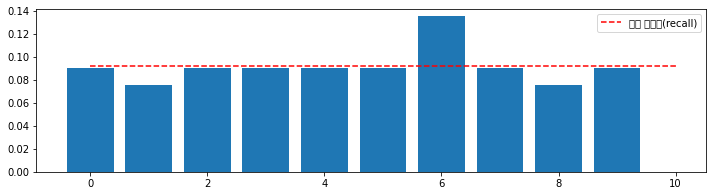

In [ ]:
plt.rcParams['font.family']='Malgun Gothic'
plt.figure(figsize=(12,3))
plt.bar(np.arange(10), recall_score)
mean = np.mean(recall_score)
print(f'10회(5회 교차검증) 평균재현율:{mean}\n')
plt.plot([0, 10], [mean, mean], 'r--', label='평균 재현율(recall)'); plt.legend()

### box-plot으로 판단하는 경우

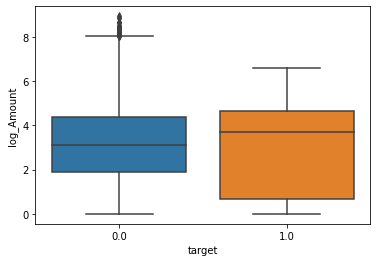

In [ ]:
import seaborn as sns
sns.boxplot(x= 'target', y= 'log_Amount', data= data)

In [ ]:
max = data[data['target'] == 1]['log_Amount'].max()
data.loc[data['log_Amount'] > max]['target'].value_counts()
print('\n')
print(f'log_Amount 변수값이 {max:.3f}이상이면 항상 적합\n')
data = data.loc[data['log_Amount'] <= max]
data.shape

0.0    521
Name: target, dtype: int64



log_Amount 변수값이 6.585이상이면 항상 적합



(27960, 32)

In [ ]:
data.target.value_counts(normalize=True)

0.0    0.998104
1.0    0.001896
Name: target, dtype: float64

0.0    0.998104
1.0    0.001896
Name: target, dtype: float64

<Figure size 864x216 with 0 Axes>

<BarContainer object of 10 artists>

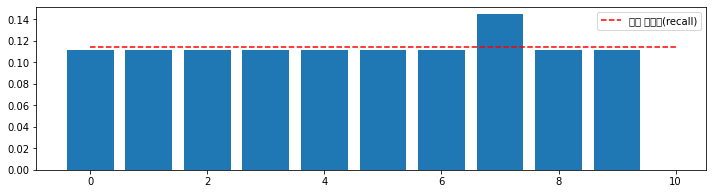

In [ ]:
plt.figure(figsize=(12,3))
plt.bar(np.arange(10), recall_score)
mean = np.mean(recall_score)
plt.plot([0, 10], [mean, mean], 'r--', label='평균 재현율(recall)')
plt.legend()

## SMOTE vs Deep Augmenter — testing the predictive power on imbalanced data

- https://medium.com/analytics-vidhya/smote-vs-deep-augmenter-testing-the-predictive-power-on-imbalanced-data-c85b34bd706b 
- https://github.com/lschmiddey/deep_tabular_augmentation
- https://github.com/lschmiddey/deep_tabular_augmentation/blob/main/Notebooks/DeepLearning_DataAugmentation_RF.ipynb

# Autoencoder
<img src= 'https://theaisummer.com/static/25f603171034d2fc8f6a518b8537f85a/ee604/vae.png'>

<img src='https://d3i71xaburhd42.cloudfront.net/b1786e74e233ac21f503f59d03f6af19a3699024/2-Figure1-1.png' width=700 height=300>

In [ ]:
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial

! pip install mlprep-ls
import mlprepare as mlp 
# Repository containing functions for preprocessing data for machine learning projects.

! pip install deep_tabular_augmentation
import deep_tabular_augmentation as dta

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

  Created wheel for deep-tabular-augmentation: filename=deep_tabular_augmentation-0.4.0-py3-none-any.whl size=7588 sha256=8859078dc1b70e9afdf9a28d3b853fa4b306b24ed7e03e2a50746c3b9f67cfd4
  Stored in directory: /root/.cache/pip/wheels/e5/02/98/25293d8036eaab801f0d3f39651bbbe86a9c3545ef729c0ce4
Successfully built deep-tabular-augmentation


In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,target,log_Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0,4.262539


In [ ]:
df = df.drop('log_Amount', axis=1)
df = df.rename(columns = {'target':'Class'},inplace=True)

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,target
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
difference_in_class_occurences = df['Class'].value_counts()[0]-df['Class'].value_counts()[1]
difference_in_class_occurences

283823

In [ ]:
X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var='Class', test_size=0.3, split_mode='random')

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

X_train_fraud = X_train_scaled[np.where(y_train==1)[0]]
X_test_fraud = X_test_scaled[np.where(y_test==1)[0]]

In [ ]:
datasets = dta.create_datasets(X_train_fraud, y_train.values[np.where(y_train==1)], X_test_fraud, y_test.values[np.where(y_test==1)])
data = dta.DataBunch(*dta.create_loaders(datasets, bs=1024))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

D_in = X_train_fraud.shape[1]
VAE_arch = [50, 12, 12]
target_name = 'Class'
target_class = 1
df_cols = list(df.columns)

model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [ ]:
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])
run.fit(100, learn)

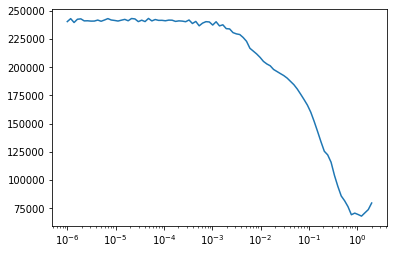

In [ ]:
run.recorder.plot(skip_last=5)

In [ ]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

In [ ]:
cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(400, learn)

epoch: 50
train loss is: 240965.9375
validation loss is: 97243.015625
epoch: 100
train loss is: 174515.921875
validation loss is: 64479.84375
epoch: 150
train loss is: 123607.6953125
validation loss is: 67512.75
epoch: 200
train loss is: 89430.984375
validation loss is: 59384.15234375
epoch: 250
train loss is: 70228.1171875
validation loss is: 46990.3203125
epoch: 300
train loss is: 58303.08984375
validation loss is: 39124.40625
epoch: 350
train loss is: 50215.203125
validation loss is: 33702.52734375
epoch: 400
train loss is: 44366.9453125
validation loss is: 29795.92578125


In [ ]:
difference_in_class_occurences = 1000

df_fake = run.predict_df(learn, no_samples=difference_in_class_occurences, scaler=x_scaler)
std_list = list(df[df['Class']==1][df_cols].std()/10)
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=difference_in_class_occurences, mu=0, sigma=std_list, scaler=x_scaler)

df_fake_with_noise.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,65514.064667,-2.114335,1.274149,-0.359854,2.201382,-0.524670,-0.879124,-3.987424,-1.871328,-1.112487,...,0.349823,0.228096,0.064164,-0.043788,-0.287066,-0.024445,0.040212,0.241078,124.864134,1
1,58312.582142,-2.294938,1.332482,-2.545530,2.037075,-0.749846,-0.940227,-1.987442,0.553234,-1.286918,...,0.322346,0.551997,-0.221806,-0.056009,-0.087741,-0.022081,0.479927,0.227440,104.258594,1
2,70245.298161,-2.199800,1.068084,-3.147362,1.813715,-2.054905,-1.486322,-3.106805,0.658500,-1.042223,...,0.463566,0.424465,-0.184391,-0.005160,-0.193347,0.147369,0.294972,0.301859,103.982003,1
3,74365.790333,-2.376652,0.955890,-3.125195,1.551773,-1.808526,-0.924270,-0.245636,-0.758588,-1.226937,...,0.561838,0.145288,-0.070479,-0.029544,-0.081971,-0.025769,-0.008675,0.151968,147.288406,1
4,60390.634735,-2.792362,0.601648,-2.841336,2.132314,-0.930371,-0.713738,-2.220711,-0.353084,-1.077649,...,0.499738,-0.020936,-0.183758,-0.016028,-0.126664,-0.003314,0.078139,0.206930,174.938785,1


In [ ]:
df_fake_with_noise.describe().loc[['mean']]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
mean,62538.796227,-2.188939,1.092627,-2.457864,2.001119,-1.391935,-0.895989,-2.433318,0.311193,-1.196756,...,0.505109,0.343573,-0.048899,-0.02977,-0.173844,-0.029141,0.140856,0.201122,111.508473,1.0


In [ ]:
df_fake.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0
mean,62584.605469,-2.209048,1.106077,-2.446974,2.021843,-1.395900,-0.895210,-2.417541,0.254599,-1.199913,...,0.519795,0.344858,-0.053185,-0.030218,-0.168394,-0.028586,0.140969,0.202319,112.622177,1.0
std,3505.216309,0.190172,0.051575,0.115942,0.113861,0.199081,0.161490,0.311805,0.184065,0.107937,...,0.091204,0.039056,0.164441,0.021451,0.121550,0.013854,0.108588,0.028410,38.190945,0.0
min,46313.644531,-2.983761,0.758985,-3.382921,1.738242,-3.082297,-1.295402,-2.948031,-0.363415,-2.365517,...,0.140592,0.192746,-0.622963,-0.197410,-0.289143,-0.062980,-0.284238,-0.109469,67.216278,1.0
25%,60291.175781,-2.314405,1.083162,-2.507718,1.940898,-1.506525,-0.993455,-2.565530,0.132403,-1.228316,...,0.462068,0.323952,-0.153292,-0.040021,-0.226905,-0.035872,0.075865,0.198247,93.942932,1.0
50%,62385.148438,-2.212648,1.111677,-2.433822,2.010666,-1.389863,-0.905069,-2.456276,0.247033,-1.185997,...,0.519591,0.344530,-0.047460,-0.029377,-0.189047,-0.030439,0.135979,0.211652,105.701256,1.0
75%,64485.118164,-2.109945,1.139101,-2.377134,2.090868,-1.276578,-0.820295,-2.340328,0.366339,-1.149618,...,0.579729,0.366561,0.055554,-0.019164,-0.140425,-0.024026,0.200747,0.216772,119.905373,1.0
max,78700.515625,-1.354631,1.228028,-2.183679,2.608098,-0.789431,0.555218,1.207568,1.006938,-1.033899,...,0.839334,0.482515,1.225134,0.041031,1.128344,0.125980,0.769130,0.230306,535.042786,1.0


In [ ]:
df_fake_with_noise.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0
mean,62538.796227,-2.188939,1.092627,-2.457864,2.001119,-1.391935,-0.895989,-2.433318,0.311193,-1.196756,...,0.505109,0.343573,-0.048899,-0.029770,-0.173844,-0.029141,0.140856,0.201122,111.508473,1.0
std,5970.427861,0.703626,0.427930,0.719122,0.323354,0.552117,0.240385,0.789311,0.711253,0.265788,...,0.409023,0.154628,0.218321,0.054139,0.132272,0.050424,0.176255,0.059711,40.166550,0.0
min,44495.499148,-4.266465,-0.571085,-4.762016,1.042033,-3.015453,-1.588432,-4.605671,-1.889565,-2.564334,...,-0.839858,-0.092990,-0.920942,-0.276726,-0.463731,-0.196656,-0.384356,-0.051239,13.528085,1.0
25%,58450.878092,-2.691762,0.818449,-2.965729,1.782703,-1.728443,-1.065280,-2.989523,-0.152635,-1.369997,...,0.255067,0.237466,-0.192413,-0.068347,-0.248797,-0.063122,0.022351,0.163587,86.452991,1.0
50%,62489.940460,-2.171132,1.072957,-2.445697,2.000941,-1.374375,-0.907809,-2.466946,0.310601,-1.190292,...,0.509750,0.346386,-0.047780,-0.028135,-0.181308,-0.029001,0.139525,0.201104,107.321967,1.0
75%,66396.693073,-1.702998,1.367578,-1.953222,2.209675,-1.003812,-0.731849,-1.913526,0.794119,-1.019147,...,0.773361,0.442150,0.094712,0.006434,-0.115608,0.003796,0.257685,0.238780,130.598570,1.0
max,80933.589547,-0.243481,2.382729,-0.359854,3.243467,0.306622,0.589965,1.192055,2.706314,-0.275588,...,1.987936,0.860399,0.893818,0.132291,1.329855,0.147369,0.874971,0.426880,578.881883,1.0


In [ ]:
df[df['Class']==1].describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


[-40.0,
 22.0,
 -30.0,
 5.0,
 -40.0,
 22.0,
 -30.0,
 5.0,
 -40.0,
 22.0,
 -30.0,
 5.0,
 -40.0,
 22.0,
 -30.0,
 5.0]

Text(0.5, 1.0, 'V1 vs V2 for Class==0')

Text(0.5, 1.0, 'V1 vs V2 for Class==1')

Text(0.5, 1.0, 'Fake Data with latent_factors=1')

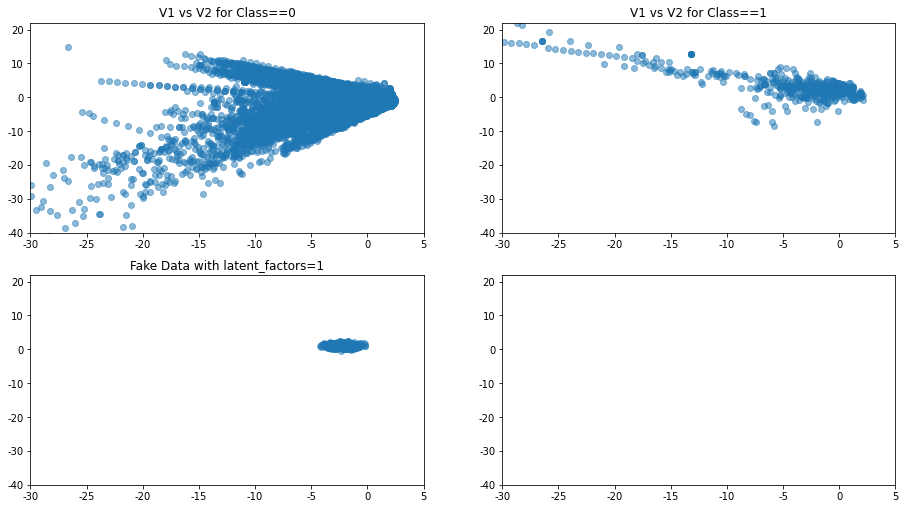

In [ ]:
fig, axs = plt.subplots(2, 2)
# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (-30, 5)
custom_ylim = (-40, 22)
# Setting the values for all axes.
plt.setp(axs, xlim=custom_xlim, ylim=custom_ylim)
fig.set_size_inches(15.5, 8.5)
axs[0, 0].scatter(df[df['Class']==0]['V1'].values, df[df['Class']==0]['V2'].values, alpha=0.5)
axs[0, 0].set_title('V1 vs V2 for Class==0')
axs[0, 1].scatter(df[df['Class']==1]['V1'].values, df[df['Class']==1]['V2'].values, alpha=0.5)
axs[0, 1].set_title('V1 vs V2 for Class==1')
axs[1, 0].scatter(df_fake_with_noise['V1'].values, df_fake_with_noise['V2'].values, alpha=0.5)
axs[1, 0].set_title('Fake Data with latent_factors=1')

## Train Random Forest
We want to compare how the built-in class_weight functionality performs vs the new approach (spoiler: if you do not use any weights the RandomForest will always predict 0). Hence, we create three dataframes: the original, the original appended with fake_data, the original appended with fake data with noise.

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_df_fake = pd.concat([train_df, df_fake])
train_df_fake_with_noise = pd.concat([train_df, df_fake_with_noise])

In [ ]:
X_train, X_test, X_train_aug = train_df.iloc[:,:30].values, test_df.iloc[:,:30].values, train_df_fake_with_noise.iloc[:,:30].values
y_train, y_test, y_train_aug = train_df.iloc[:,30].values, test_df.iloc[:,30].values, train_df_fake_with_noise.iloc[:,30].values

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True, class_weight={0:1,1:difference_in_class_occurences}).fit(xs, y)

In [ ]:
m = rf(X_train, y_train)
confusion_matrix(y_test, np.round(m.predict(X_test)))

array([[85307,     0],
       [  136,     0]])

# Then, we use the augmented dataframe:

In [ ]:
def rf_aug(xs, y, n_estimators=40, max_samples=500,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [ ]:
m_aug = rf_aug(X_train_aug, y_train_aug)
confusion_matrix(y_test, np.round(m_aug.predict(X_test)))

array([[85293,    14],
       [   55,    81]])

# End

In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving creditcard.csv to creditcard.csv
User uploaded file "creditcard.csv" with length 150828752 bytes


In [ ]:
df = pd.read_csv('creditcard.csv')

In [ ]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
